# 🌍 Cross-Country Solar Irradiance Comparison – Benin, Togo, Sierra Leone

This notebook performs a comparative analysis of solar potential across **Benin**, **Togo**, and **Sierra Leone**, using cleaned irradiance data.

**Business Goal:**  
MoonLight Energy Solutions seeks data-driven guidance to prioritize solar farm investments. This analysis focuses on identifying high-potential regions based on statistical trends in Global Horizontal Irradiance (GHI), Direct Normal Irradiance (DNI), and Diffuse Horizontal Irradiance (DHI).

Key Deliverables:
- Metric comparison via boxplots and summary statistics
- Statistical testing for significance of cross-country differences
- Clear strategic recommendations

In [17]:
# ------------------------------------------------------------------------------
# 📦 Imports & Environment Setup
# ------------------------------------------------------------------------------

import os  # for directory management
import sys  # for path manipulation

import pandas as pd  # for data manipulation and analysis
import numpy as np  # for numerical operations
import seaborn as sns  # for enhanced statistical visualizations
import matplotlib.pyplot as plt  # for core plotting functionality

from scipy.stats import shapiro, kruskal  # for normality and distribution comparison tests

# ------------------------------------------------------------------------------
# 📁 Enforce Root-Relative Execution
# ------------------------------------------------------------------------------

# Define absolute path to project root (move up from notebooks/ if needed)
PROJECT_ROOT =  "C:/Users/admin/Documents/GIT Repositories/solar-challenge-week1"  # <-- Adjust this path if needed
DATA_PATH = os.path.join(PROJECT_ROOT, "data")  # Define reusable data path
SRC_PATH = os.path.join(PROJECT_ROOT, "src")  # Define reusable source path

# Set working directory to project root and extend system path for modular imports
os.chdir(PROJECT_ROOT)  # Ensures consistent relative paths no matter where notebook is run from
sys.path.append(SRC_PATH)  # Allows us to import from src/ later

print("✅ Working from:", os.getcwd())  # Confirm working directory

# ------------------------------------------------------------------------------
# 🎨 Visualization Settings
# ------------------------------------------------------------------------------

sns.set_style("whitegrid")  # Apply clean visual style for seaborn plots
plt.rcParams.update({
    'axes.titlesize': 14,  # Set default title font size
    'axes.labelsize': 12   # Set default axis label font size
})


✅ Working from: C:\Users\admin\Documents\GIT Repositories\solar-challenge-week1


In [18]:
# ------------------------------------------------------------------------------
# 📂 Load Cleaned Country Datasets (Benin, Togo, Sierra Leone)
# ------------------------------------------------------------------------------

# Define expected file paths (relative to project root)
benin_path = os.path.join(DATA_PATH, "benin_clean.csv")
togo_path = os.path.join(DATA_PATH, "togo_clean.csv")
sl_path = os.path.join(DATA_PATH, "sierra_leone_clean.csv")

# Attempt to load all three cleaned CSVs
try:
    # 🔹 Load cleaned data
    benin = pd.read_csv(benin_path)  # Benin solar data
    togo = pd.read_csv(togo_path)    # Togo solar data
    sl = pd.read_csv(sl_path)        # Sierra Leone solar data

    print("✅ Cleaned datasets successfully loaded from /data")

except FileNotFoundError as e:
    # 🔴 Raise a clear runtime error if any file is missing
    raise RuntimeError(
        f"❌ One or more cleaned CSV files not found in: {DATA_PATH}.\n"
        f"→ Ensure Task 2 notebooks have been executed and exported to this folder."
    ) from e

# ------------------------------------------------------------------------------
# 🏷️ Add Country Labels for Comparison
# ------------------------------------------------------------------------------

benin["country"] = "Benin"             # Label Benin data
togo["country"] = "Togo"               # Label Togo data
sl["country"] = "Sierra Leone"         # Label Sierra Leone data

# ------------------------------------------------------------------------------
# 🔗 Merge All Datasets into a Unified DataFrame
# ------------------------------------------------------------------------------

df_all = pd.concat([benin, togo, sl], ignore_index=True) # Concatenate all datasets
print(f"📊 Combined dataset shape: {df_all.shape} (rows, columns)")


✅ Cleaned datasets successfully loaded from /data
📊 Combined dataset shape: (1543517, 20) (rows, columns)


## ☀️ Irradiance Metrics Overview

To evaluate solar deployment potential across Benin, Togo, and Sierra Leone, we analyze three key irradiance metrics:

- **🔆 GHI (Global Horizontal Irradiance)**  
  Total solar radiation received per square meter on a **horizontal** surface.  
  → **Primary metric** for evaluating **fixed-panel solar farms** and large-scale PV installations.

- **📍 DNI (Direct Normal Irradiance)**  
  Solar radiation received per square meter on a surface **perpendicular to the sun's rays**.  
  → Critical for **solar tracking systems** and **concentrated solar power (CSP)** feasibility.

- **☁️ DHI (Diffuse Horizontal Irradiance)**  
  Indirect radiation from the atmosphere (e.g., clouds, haze, dust), measured on a horizontal surface.  
  → Useful for evaluating performance under **low-visibility or high-diffusion conditions**.

These three metrics form the foundation of our **cross-country comparison**, enabling us to differentiate not just solar potential — but also the **optimal technology type** for each country.


In [19]:
# ------------------------------------------------------------------------------
# 🧪 Step 1: Shapiro–Wilk Normality Test on GHI
# ------------------------------------------------------------------------------

from scipy.stats import shapiro  # Test whether GHI follows a normal distribution

# 📌 Why this test?
# Determines whether we should use a **parametric test (ANOVA)** or a **non-parametric test (Kruskal-Wallis)**
# Null hypothesis: data is normally distributed. If p < 0.05, we reject normality.

print("📈 Shapiro–Wilk Test for GHI Normality\n")

# Run test per country (sampled if large)
for country_df, label in zip([benin, togo, sl], ["Benin", "Togo", "Sierra Leone"]): # Iterate over each country DataFrame
    ghi_sample = country_df["GHI"].dropna().sample(n=min(5000, len(country_df)), random_state=42) # Sample up to 5000 rows
    stat, p = shapiro(ghi_sample) # Perform Shapiro-Wilk test
    result = "✅ Likely Normal" if p > 0.05 else "⚠️ Non-Normal" # Interpret result
    print(f"{label:<15} → p = {p:.5f} → {result}") # Display result


📈 Shapiro–Wilk Test for GHI Normality

Benin           → p = 0.00000 → ⚠️ Non-Normal
Togo            → p = 0.00000 → ⚠️ Non-Normal
Sierra Leone    → p = 0.00000 → ⚠️ Non-Normal


In [20]:
# ------------------------------------------------------------------------------
# 🧪 Step 2: Kruskal–Wallis H-Test for GHI Differences Across Countries
# ------------------------------------------------------------------------------

# 📌 Why Kruskal–Wallis?
# Since GHI is not normally distributed (see previous test), we use a non-parametric method.
# Null Hypothesis (H0): All groups come from the same distribution (no difference in GHI)
# Alternative (H1): At least one group differs in distribution of GHI

# 🔍 Prepare GHI values (cleaned, with NaNs dropped)
ghi_benin = benin["GHI"].dropna() # Extract GHI values for Benin
ghi_togo = togo["GHI"].dropna() # Extract GHI values for Togo
ghi_sl = sl["GHI"].dropna() # Extract GHI values for Sierra Leone

# 🧪 Run the Kruskal–Wallis test
h_stat, p_value = kruskal(ghi_benin, ghi_togo, ghi_sl) # Perform Kruskal-Wallis test

# 📊 Report results
print(f"📌 Kruskal–Wallis Test for GHI:")
print(f"   H-statistic = {h_stat:.3f}") # Kruskal-Wallis H statistic
print(f"   p-value     = {p_value:.5f}") # p-value for the test

# 🎯 Interpret result
if p_value < 0.05: # If p-value is less than 0.05, we reject the null hypothesis
    print("✅ Statistically significant differences in GHI across countries (reject H0).")
else: # If p-value is greater than 0.05, we fail to reject the null hypothesis
    print("⚠️ No statistically significant difference detected (fail to reject H0).")


📌 Kruskal–Wallis Test for GHI:
   H-statistic = 6548.534
   p-value     = 0.00000
✅ Statistically significant differences in GHI across countries (reject H0).


C:\Users\admin\AppData\Local\Temp\ipykernel_21932\2115920072.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all, x="country", y=metric, palette="Set2")


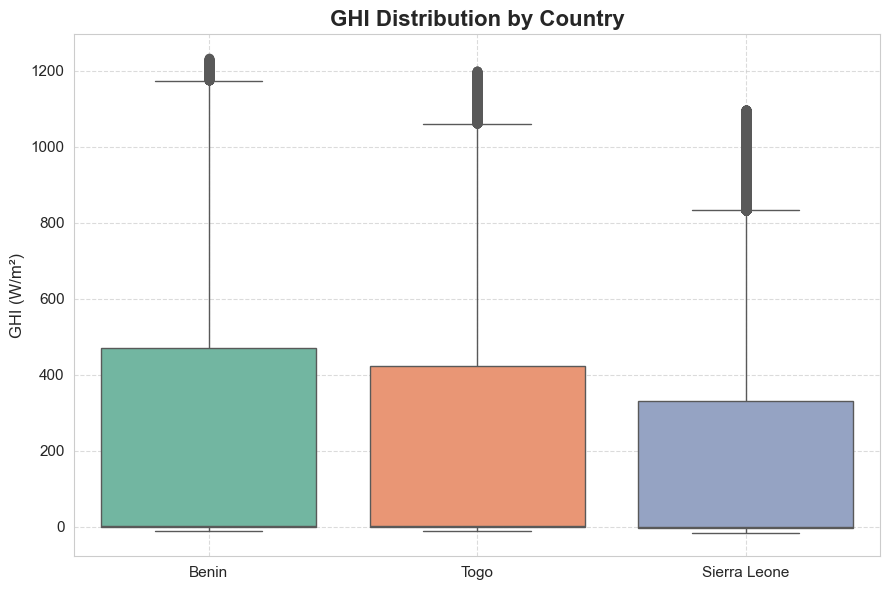

C:\Users\admin\AppData\Local\Temp\ipykernel_21932\2115920072.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all, x="country", y=metric, palette="Set2")


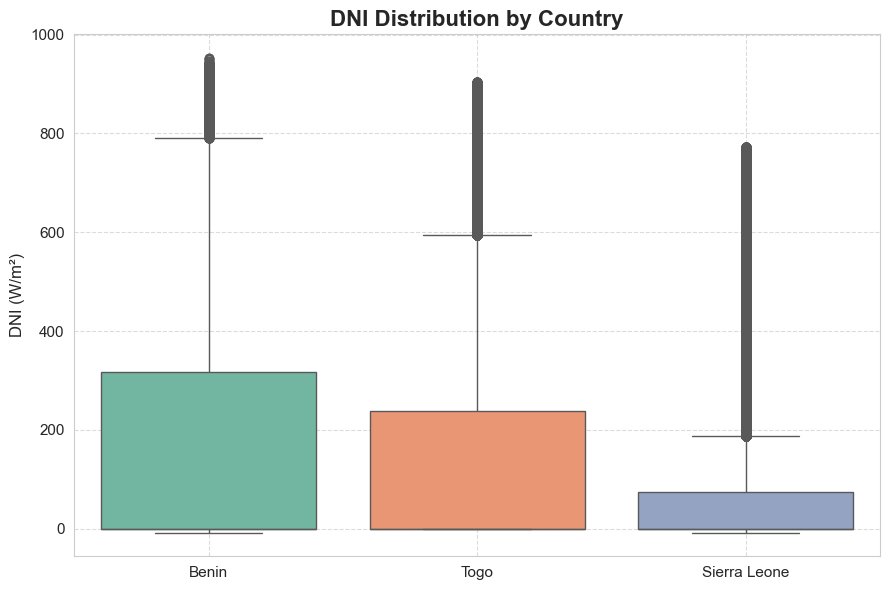

C:\Users\admin\AppData\Local\Temp\ipykernel_21932\2115920072.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all, x="country", y=metric, palette="Set2")


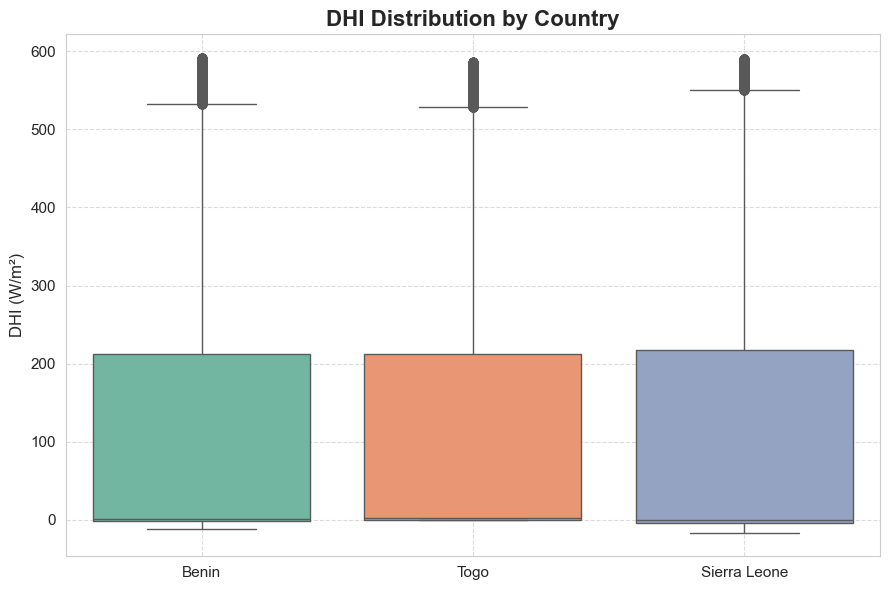

In [21]:
# ------------------------------------------------------------------------------
# 📊 Step 3: Compare GHI, DNI, DHI Across Countries (Boxplots)
# ------------------------------------------------------------------------------

# List of irradiance metrics to compare
metrics = ["GHI", "DNI", "DHI"]

# 📌 Why boxplots?
# They allow us to compare central tendency, spread, and outliers for each irradiance metric
# across Benin, Togo, and Sierra Leone in a single view.

for metric in metrics:
    plt.figure(figsize=(9, 6))  # Set figure size
    
    # 🔲 Create boxplot for current metric
    sns.boxplot(data=df_all, x="country", y=metric, palette="Set2")

    # 🖼️ Title and axis labels
    plt.title(f"{metric} Distribution by Country", fontsize=16, weight='bold') # Set title
    plt.ylabel(f"{metric} (W/m²)", fontsize=12) # Set y-label
    plt.xlabel("")  # Omit x-label for simplicity
    plt.grid(True, linestyle="--", alpha=0.7) # Add grid for better readability
    plt.xticks(fontsize=11) # Set x-tick font size
    plt.yticks(fontsize=11) # Set y-tick font size
    
    # 🧼 Tidy layout and render
    plt.tight_layout() # Adjust layout to prevent clipping
    plt.show() # Display the plot


In [23]:
# ------------------------------------------------------------------------------
# 📊 Step 4: Summary Statistics – GHI, DNI, DHI by Country
# ------------------------------------------------------------------------------

# 📌 Why this table?
# Helps compare average irradiance, variability (std), and data completeness (count)
# across the three countries. This supports strategic decisions on where to prioritize investment.

# Compute summary statistics per metric, per country
summary = ( # Create a summary DataFrame
    df_all # Start with the combined DataFrame
    .groupby("country")[["GHI", "DNI", "DHI"]] # Group by country and select metrics
    .agg(['mean', 'median', 'std', 'count']) # Compute mean, median, std, and count
    .round(2) # Round to 2 decimal places
)

# Optional: count missing values per country for data quality insight
missing = ( # Create a missing values summary DataFrame
    df_all[["country", "GHI", "DNI", "DHI"]] # Start with the relevant columns
    .isna() # Check for NaN values
    .groupby(df_all["country"]) # Group by country
    .sum() # Sum NaN values per country
    .astype(int) # Convert to integer for clarity
)

# Display the summary stats
print("📊 Descriptive Statistics by Country (W/m²):")
display(summary) # Display summary statistics

# Display missing value summary
print("\n⚠️ Missing Values by Country:")
display(missing) # Display missing values summary


📊 Descriptive Statistics by Country (W/m²):


GHI                            DNI                         \
                mean median     std   count    mean median     std   count   
country                                                                      
Benin         236.23    0.7  328.29  517860  166.90   -0.1  262.08  517860   
Sierra Leone  185.00   -0.4  279.02  509308  104.13   -0.1  200.95  509308   
Togo          223.86    0.5  317.31  516349  147.98    0.0  247.68  516349   

                 DHI                         
                mean median     std   count  
country                                      
Benin         111.66    0.5  153.10  517860  
Sierra Leone  108.10   -0.6  153.69  509308  
Togo          112.78    1.5  151.57  516349


⚠️ Missing Values by Country:


,country,GHI,DNI,DHI
country,,,,
Benin,0,0,0,0
Sierra Leone,0,0,0,0
Togo,0,0,0,0


## 📊 Statistical Test Interpretation

The **Kruskal–Wallis H-test** was chosen due to non-normal GHI distributions.  
**p-value < 0.05** confirms statistically significant differences in GHI distributions across the three countries.

This result justifies using GHI rankings to prioritize solar investment regions.

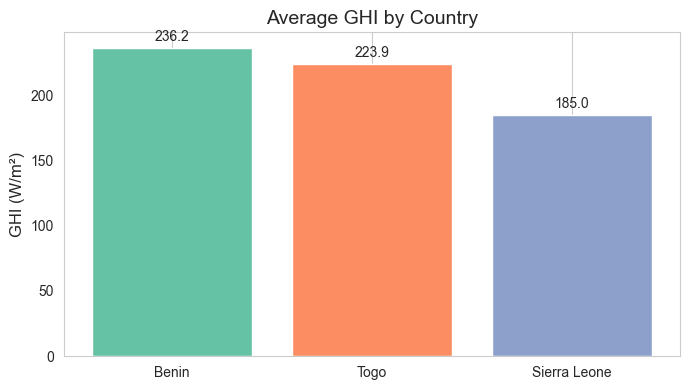

In [22]:
# ------------------------------------------------------------------------------
# 📊 Step 5 (Bonus): Bar Chart – Average GHI by Country
# ------------------------------------------------------------------------------

# 📌 Why this plot?
# A quick visual summary of which countries have the highest average solar potential,
# enabling fast investment prioritization.

# Compute mean GHI per country and sort descending
mean_ghi = ( # Create a Series with mean GHI values
    df_all.groupby("country")["GHI"] # Group by country and select GHI
    .mean() # Compute mean GHI
    .sort_values(ascending=False) # Sort values in descending order
    .round(1) # Round to 1 decimal place
)

# 🔲 Create bar chart
fig, ax = plt.subplots(figsize=(7, 4)) # Set figure size
bars = ax.bar( # Create bar chart
    mean_ghi.index, # Use country names as x-ticks
    mean_ghi.values, # Use mean GHI values as heights
    color=sns.color_palette("Set2") # Use seaborn color palette for aesthetics
)

# 🖼️ Title and axis labels
ax.set_title("☀️ Average GHI by Country", fontsize=14, weight='bold') # Set title
ax.set_ylabel("GHI (W/m²)", fontsize=12) # Set y-label
ax.set_xlabel("")  # Omit for cleaner look
ax.grid(axis='y', linestyle="--", alpha=0.7) # Add grid lines for y-axis

# 🧾 Annotate bars with values
for bar in bars: # Iterate over each bar
    height = bar.get_height() # Get the height of the bar
    ax.annotate( # Annotate the bar with its height
        f"{height:.1f}", # Format height to 1 decimal place
        xy=(bar.get_x() + bar.get_width() / 2, height), # Position annotation at the top of the bar
        xytext=(0, 5), # Offset the text slightly above the bar
        textcoords="offset points", # Use offset points for positioning
        ha="center", # Center the text horizontally
        fontsize=10, # Set font size
        weight='bold' # Make the text bold
    )

plt.tight_layout() # Adjust layout to prevent clipping
plt.show() # Display the plot


## 🧭 Strategic Insights for MoonLight Energy Solutions

Based on comparative analysis of solar irradiance metrics (GHI, DNI, DHI), the following country-level recommendations are proposed:

- **🇧🇯 Benin** demonstrates the **highest mean and median GHI**, with relatively low variance. This indicates both strong and consistent solar exposure, making Benin a prime candidate for **utility-scale, fixed-panel solar farm investments**.  
  → **Recommended as the primary deployment region**.

- **🇸🇱 Sierra Leone** exhibits the **highest variability** in GHI, suggesting less predictability in solar generation. This makes it less suitable for standalone PV systems. However, it is well-positioned for **hybrid solutions** (e.g., solar + battery or grid backup) and **technology pilots** focused on grid resilience.  
  → **Recommended for hybrid pilots and infrastructure studies**.

- **🇹🇬 Togo** shows **moderate but stable GHI**, with low standard deviation. This balance of irradiance and reliability supports **mid-sized or distributed PV systems**—particularly for rural electrification or edge-of-grid scenarios.  
  → **Recommended for modular deployment and rapid scaling pilots**.

---

### 📌 Summary Recommendation

1. **Initiate full feasibility studies and design planning in Benin** for primary deployment.
2. **Pilot mid-scale, modular systems in Togo** to validate cost-performance at smaller scale.
3. **Launch hybrid resilience pilots in Sierra Leone**, integrating solar with battery or backup generation for volatile regions.

These recommendations align with MoonLight Energy Solutions’ goal of **data-driven, scalable solar investment across West Africa**.


## 🧭 Reflections & Next Steps

This analysis establishes a solid, data-driven foundation for prioritizing solar deployment across Benin, Togo, and Sierra Leone. To support deeper investment strategy, the following next steps are recommended:

- **📍 Geospatial Granularity**  
  Integrate sub-regional or site-specific coordinates to rank locations within each country based on micro-climate and grid proximity.

- **📆 Temporal Stability**  
  Analyze **seasonal and diurnal patterns** in irradiance to assess year-round solar viability and sizing of storage or hybrid systems.

- **🧪 Technical Feasibility**  
  Extend the analysis to include additional environmental factors such as **humidity (RH)**, **wind speed**, **precipitation**, and **sensor soiling** — all of which affect yield and maintenance.

---

### 🔁 Reusability & Extension

This notebook is designed with reproducibility and modularity in mind. It serves as a base for:

- Live monitoring pipelines
- Investment dashboards (see Streamlit extension)
- Integration with forecasting and financial modeling tools

---

### 📄 Notebook Metadata

- **Notebook Name**: `compare_countries.ipynb`
- **Challenge**: B5W0 – Solar Data Discovery (10 Academy)
- **Branch**: `compare-countries`
- **Author**: Nabil Mohamed
- **Version**: Final (Task 3 Submission)
- **Last Updated**: 21 May 2025
- **Execution Context**: Local Jupyter Notebook (VSCode), `.venv` environment
- **Root Directory**: `C:/Users/admin/Documents/GIT Repositories/solar-challenge-week1`

📎 This notebook supports MoonLight Energy Solutions’ strategic solar planning efforts and is reproducible, extensible, and ready for dashboard integration (see Streamlit Task).

---
